In [1]:
import matplotlib.pyplot as plt
import skimage.io as skio
import skimage
import numpy as np
import numpy.fft as fft
from scipy import ndimage
from skimage import data
from skimage.color import rgb2hsv
from skimage.color import  hsv2rgb
from skimage.transform import resize

# Introduction to pansharpening

The goal of this practical work is to introduce the pansharpening problem and a few basic solutions to this problem. Pansharpening objective is to merge two images of a same scene:
1) A high spatial resolution image having however a low spectral resolution. Such an image will be denoted HR-LS (high resolution - low spectral) in the following.
2) A low spatial resolution image having however a high spectral resolution. Such an image will be denoted LR-HS (low resolution - high spectral) in the following.

The objective of such a combination is to obtain the best of the two modalities, that is, to obtain numerically a high spatial resolution image having also a high spectral resolution, which will be denoted as HR-HS in the following.

In this practical work, we will consider two use-cases:
- The fusion of a grayscale image having a high spatial resolution (the HR-LS) with a RGB image of lower resolution (the LR-HS).
- The fusion of a multispectral image having a high spatial resolution (the HR-LS) with a hyperspectral image (HSI) of lower resolution (the LR-HS). For an example, see the figure below: the X image is the HSI and the Y is the multispectral image. The pansharpened image is given on the right.

![Alt text](Illustration_pansharpening.jpeg?raw=true "Title")

While the two above problems share similarities, properly taking into account the high spectral resolution of hyperspectral images calls for dedicated tools, that we will see in the second part of the practical work.

# I - Fusion of a grayscale and a RGB image

## I - 1) Dataset

Before starting, let us have a look to the images provided in the image folder. For each dataset, three images are provided:
- the grayscale image
- the RGB image
- the "ground-truth" image, which corresponds to the high spatial high spectral resolution image. Of course, in real life, you would not have access to such an image, but it is provided here to compare the pansharpening results with the ideal image.

In [3]:
GS=skio.imread('Images/RGB/valfruits.tif')/255
RGB=skio.imread('Images/RGB/subfruits.tif')/255
GT=skio.imread('Images/RGB/fruits.tif')/255

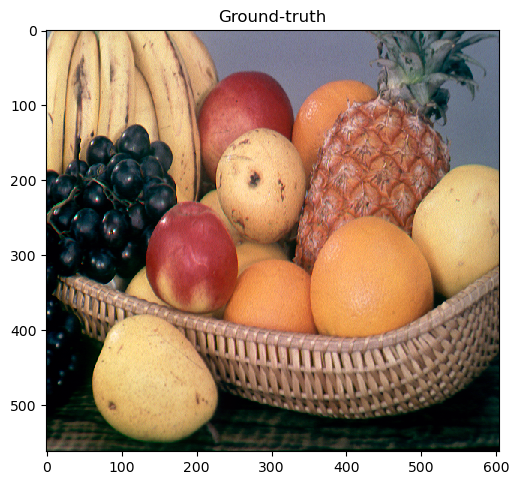

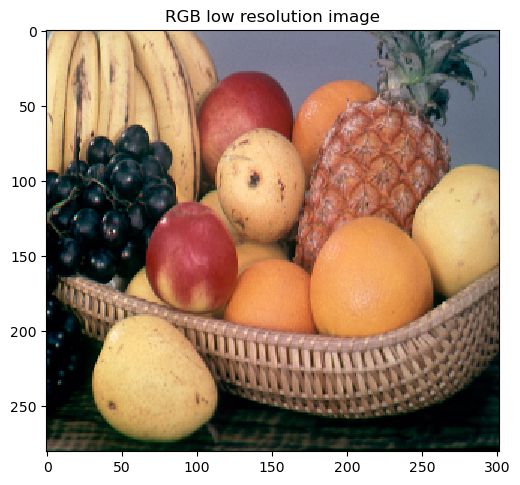

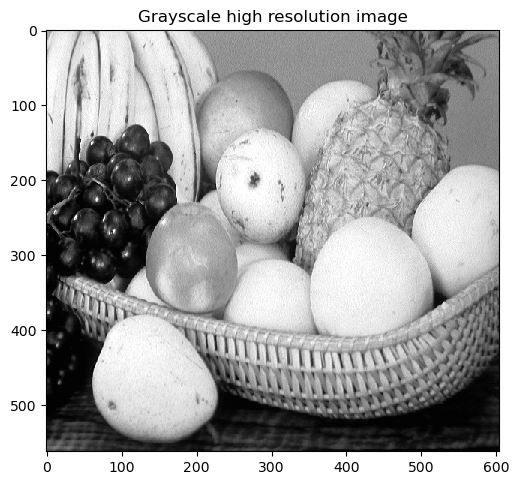

In [4]:
skio.imshow(GT)
plt.title('Ground-truth')
plt.show()
skio.imshow(RGB)
plt.title('RGB low resolution image')
plt.show()
skio.imshow(GS)
plt.title('Grayscale high resolution image')
plt.show()

Describe what you observe in each of the (GT, RGB, GS) image: can you see the differences in resolution? What are the resolutions of each image?

**Answer:** 

Now that we have understood the dataset, let us turn toward the pansharpening itself. The pansharpening methods between a RGB and a grayscale image can be divided into two main families:
- the substitution methods, where some components of the RGB image (usually, the intensity channel) are replaced by the grayscale image ;
- the multi-resolution methods, where the details of the grayscale image are isolated at different resolution levels and added to the RGB image.

The two following subsections explore each family.

## I - 2) Substitution methods

Substitution methods follow the general following scheme:
1) oversampling of the RGB image at the grayscale resolution
2) transformation of the resulting image in a new representation space enabling to isolate the intensity information (e.g. using a new color space such a HSV)
3) replacement of the intensity by the grayscale image. Potentially, perform first a normalization step.
4) inverse transform of the resulting image into the initial representation space.

### I - 2 - 1) Fusion using the HSV colorspace

Let us do the fusion using the algorithm described above, in the HSV space. To do that: first convert the RGB image to the RGB colorspace. Then, oversample the HSV image using the resize(..., order=1) function and replace the intensity component by the GS image.

In [5]:
hsv=...(RGB)
s=GS.shape
sur=...(...,(...,...,...),order=1)
sur[:,:,...] = GS
pan = ...(sur)

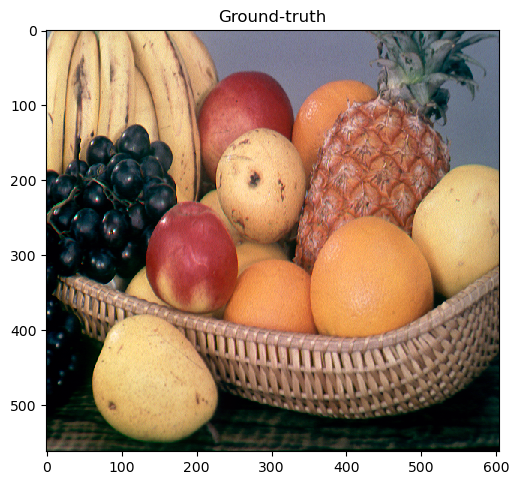

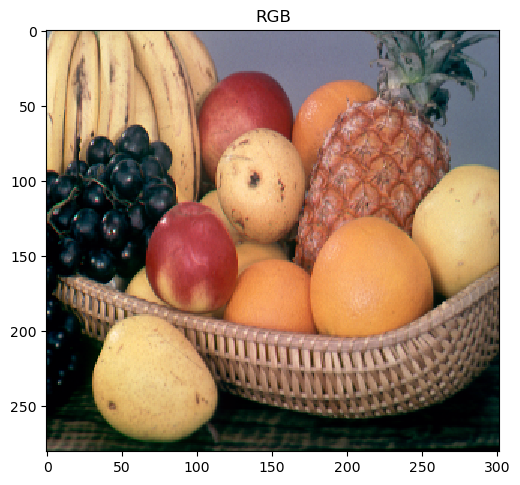

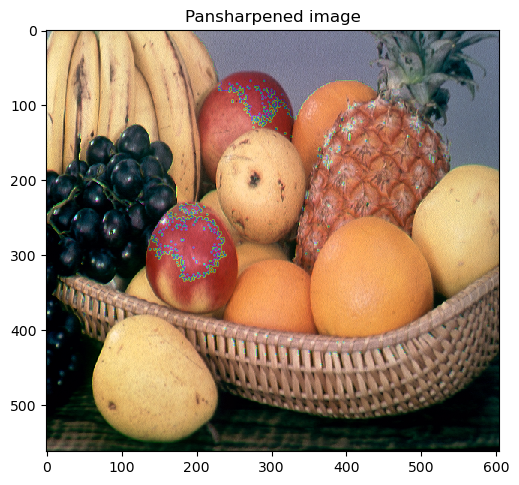

In [6]:
skio.imshow(GT)
plt.title('Ground-truth')
plt.show()

skio.imshow(RGB)
plt.title('RGB')
plt.show()

skio.imshow(pan)
plt.title('Pansharpened image')
plt.show()

Which default do you observe in the pansharpened image?

**Answer:** 

How do you explain the above default? To answer, cheat by replacing in the HSV pansharpened image the color information by the one of the groundtruth.

**Answer:** 

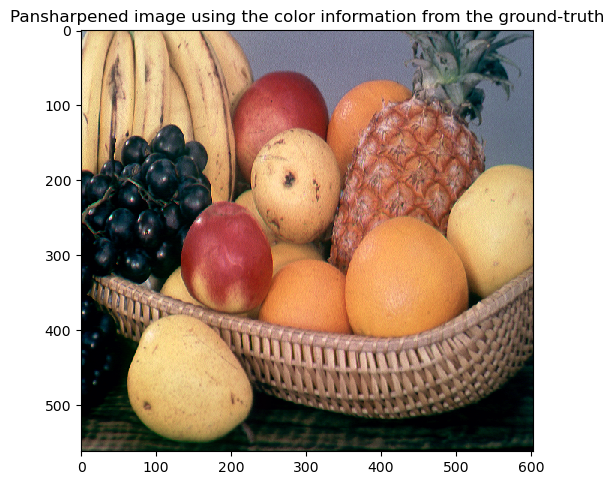

In [7]:
# You can start from the code you wrote above


### I - 2 - 2) Fusion using PCA

Instead of using a predefined color space transform as above, let us learn the transform from the image itself using a PCA. The method is the following:
- compute the PCA of the image
- change the 1st principal component by the grayscale image. The rational behing that is that the component with the largest variance / the most information can be associated to the intensity. Do a normalization to ensure the variance of the grayscale image to be the same as the one of the original component
- compute the inverse PCA

In [8]:
from sklearn.decomposition import PCA

s=GS.shape
newms=resize(RGB,(s[0],s[1],3),order=1)

x = newms.reshape(-1, 3)

pca = PCA(n_components=3, svd_solver='full')
pca.fit(...)

scores = pca.fit_transform(x)

GSl=np.double(GS.reshape(-1))

indice = 0
newcoord = ... # Center the GSl, and ensure that its variance is the same as the one of np.std(scores[:,indice])
scores[:,indice] = newcoord

imSub = pca.inverse_transform(...)# Back-transform

imSub = imSub.reshape((s[0],s[1],3))



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


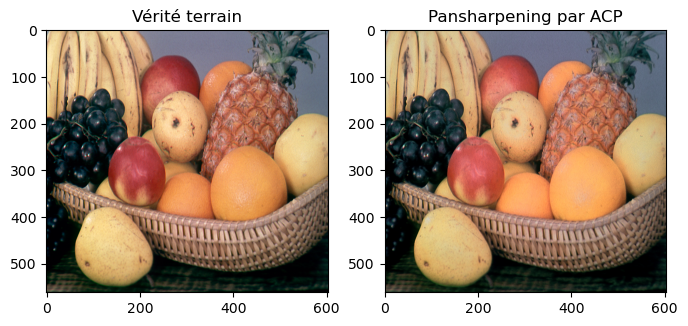

In [10]:
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(GT)
plt.title('Ground truth')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(imSub)
plt.title('Pansharpening through PCA')
plt.show()

Compare your result with the one using HSV.

**Answer:**

Try to substitute the grayscale image to other PCA channels. Does it work well?

**Answer:** 

## I - 3) Multiresolution analysis (MRA) methods

Multiresolution analysis (MRA) is a second pansharpening family. They apply a spatial filter to the HR-LS image for generating details to be injected into the LR-HS data. These methods generally write as :
- oversampling of the LR-HS image at the HR-LS image resolution
- (optionnally, adjustment of the HR-LS radiometry to each LR-HS channel radiometry)
- for each resolution between the two images, detail detection in the HR-LS image by substraction of a (low-pass) filtered image. Then, injection of these details into the LR-HS.

In this part, we will use one of the most basis MRA method: the Fourier pansharpening method. The idea is to replace, in the Fourier domain, the high frequencies of the LR-HS image by the ones of the HR-LS, since the HR-LS has a higher spatial resolution.

Explain what the following code does.

**Answer:**

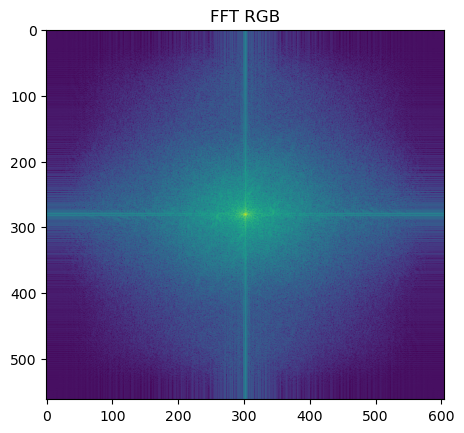

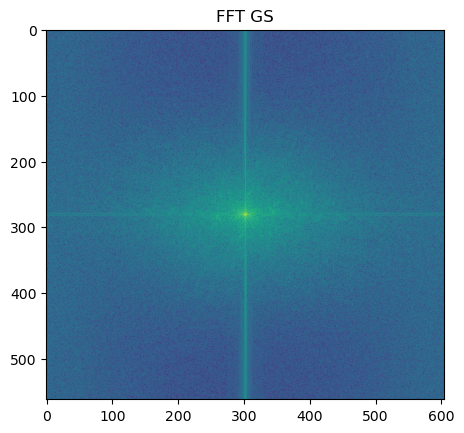

In [11]:
s=GS.shape
surRGB=resize(RGB,(s[0],s[1],3),order=1)

fftRGB=np.fft.fftshift(np.fft.fft2(surRGB,axes=(0,1)),axes=(0,1))

fftGS=np.fft.fftshift(np.fft.fft2(GS))



##### Merely for visualization
visufftRGB=np.log((np.abs(fftRGB[:,:,0])+0.1))
visufftRGB=visufftRGB/np.max(visufftRGB)
plt.imshow(visufftRGB)
plt.title('FFT RGB')
plt.show()

visufftGS=np.log((np.abs(fftGS)+0.1))
visufftGS=visufftGS/np.max(visufftGS)
plt.imshow(visufftGS)
plt.title('FFT GS')
plt.show()

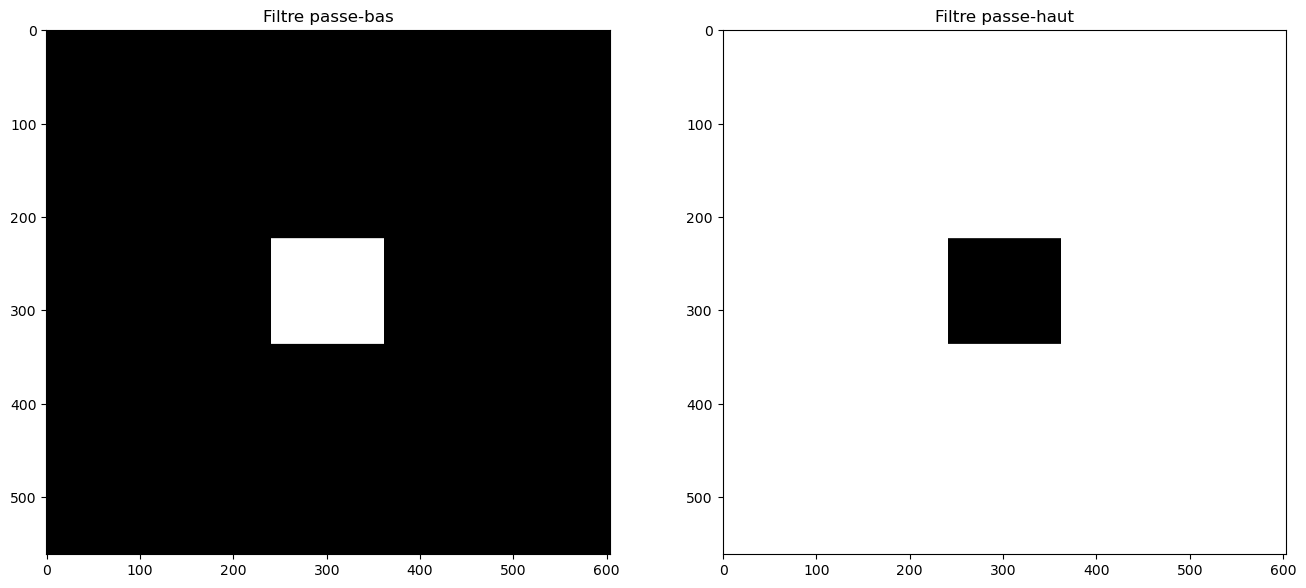

In [12]:
passebas = np.zeros((s[0],s[1]),dtype=np.float32)

passebas[np.uint32(s[0]*(1/2-1/10)):np.uint32(s[0]*(1/2+1/10)),np.uint32(s[1]*(1/2-1/10)):np.uint32(s[1]*(1/2+1/10))]=1


# Hanning filter
#passebasy = np.zeros((s[0],1),dtype=np.float32)
#passebasx = np.zeros((1,s[1]),dtype=np.float32)

#passebasy2=np.hanning(s[0])
#passebasx2=np.hanning(s[1])
#for i in range(s[0]):
#    passebasy[i,0] = passebasy2[i]

#for i in range(s[1]):
#  passebasx[0,i] = passebasx2[i]
    
#passebas=np.dot(passebasy,passebasx)

## Filtre passe-haut

passehaut=1-passebas


fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(passebas,cmap="gray")
plt.title('Filtre passe-bas')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow((passehaut),cmap="gray")
plt.title('Filtre passe-haut')
plt.show()

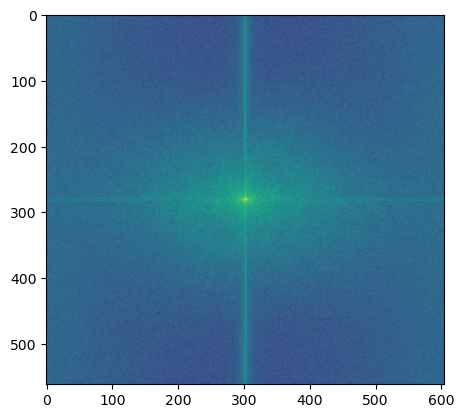

In [13]:
fftHRHS1=passebas*fftRGB[:,:,0]+passehaut*fftGS;
fftHRHS2=passebas*fftRGB[:,:,1]+passehaut*fftGS;
fftHRHS3=passebas*fftRGB[:,:,2]+passehaut*fftGS;


visufftHRHS1=np.log((np.abs(fftHRHS1)+0.1))
visufftHRHS1=visufftHRHS1/np.max(visufftHRHS1)
plt.imshow(visufftHRHS1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, "Pansharpening dans l'espace de Fourier")

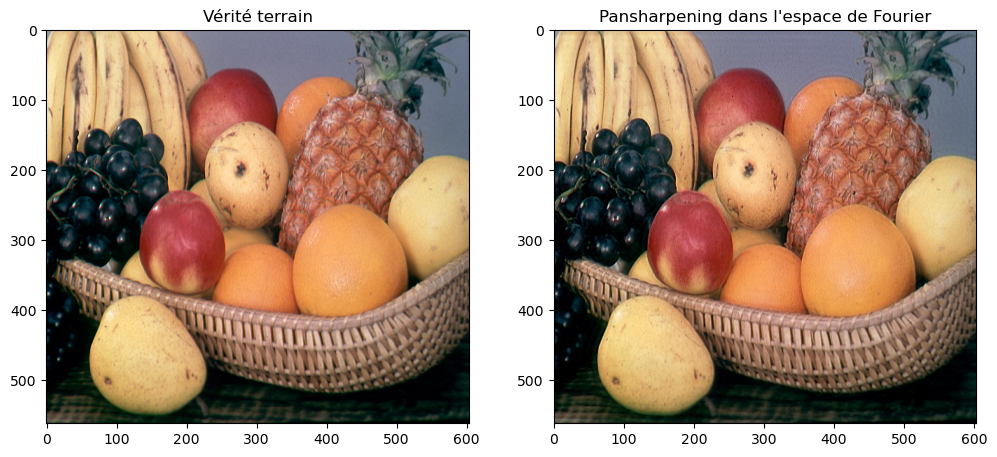

In [14]:
HRHS = np.zeros((s[0],s[1],3),dtype=np.float32)

HRHS[:,:,0]=np.real(np.fft.ifft2(np.fft.fftshift(fftHRHS1)))
HRHS[:,:,1]=np.real(np.fft.ifft2(np.fft.fftshift(fftHRHS2)))
HRHS[:,:,2]=np.real(np.fft.ifft2(np.fft.fftshift(fftHRHS3)))


fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(GT)
plt.title('Vérité terrain')
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(HRHS)
plt.title("Pansharpening dans l'espace de Fourier")

What do you observed in the pansharpened image? Explain the reasons of the artefacts you see.

**Answer:** 

Try broader low-pass filters. What difference do you observe?

**Answer:** 

Try a Hanning filter by uncommenting the provided code. What difference do you see and why?

**Answer:** 

# II - Hyperspectral pansharpening

Now, let us turn towards hyperspectral pansharpening. This is a highly complicated problem since hyperspectral images carry much more colorimetric information than RGB image and suffer from a very low spatial resolution. Consequently, it is very difficult to fuse a grayscale image with an hyperspectral one, and usually a simpler problem is considered: the fusion of a multispectral image with an hyperspectral image. We will consider dedicated tools, using hyperspectral unmixing, to solve this problem.

## II - 1) Data

We here consider the "chikusei" dataset, which contains an hyperspectral image. To be able to assess the quality of the algorithms we will developp, we will work on two synthetic images generated from the chikusei dataset. Precisely, the code below enables to simulate a HSI image by deteriorating by a factor 6 the number of pixels in the chikusei HSI, and to simulate a MSI by deteriorating the spectral content.

In [15]:
from CNMF import gaussian_down_sample,zoom_bi,zoom_nn

In [16]:
# Read image
filename = 'chikusei.bsq'
cols1 = 240
rows1 = 240
bands1 = 128
data = np.transpose( np.double(np.fromfile(filename, dtype = np.uint16, count = cols1 * bands1 * rows1).reshape(bands1, rows1, cols1) ), (1,2,0))
hs_bands = np.r_[4:114]
data = data[:,:,hs_bands] # Exclude noisy bands
bands1 = data.shape[2]

# Synthesize MSI
print('Synthesize MSI ...')
with open('chikusei_spec.txt', "r") as f:
    spec = map(lambda x:x.split(), f.read().strip().split("\n"))
spec = np.array([[float(elm) for elm in v] for v in spec])
wavelength = spec[hs_bands,0] # Center wavelength of HSI
RapidEye_wavelength = np.array([[0.440, 0.510],[0.520, 0.590], [0.630, 0.690], [0.690, 0.730], [0.760, 0.880]]) # Spectral range of RapidEye
bands2 = RapidEye_wavelength.shape[0] # Number of MSI bands
srf = np.zeros((bands2,bands1))
for b in range(bands2):
    b_i = np.nonzero(wavelength>RapidEye_wavelength[b,0])[0][0]
    b_e = np.nonzero(wavelength<RapidEye_wavelength[b,1])[0][-1]
    srf[b,b_i:b_e+1] = 1.0/(b_e+1-b_i) # Rectangle SRF
MSI = np.dot(data.reshape(cols1*rows1,bands1), srf.transpose()).reshape(rows1,cols1,bands2) # Spectral simulation

# Synthesize HSI
print('Synthesize HSI ...')
w = 6 # GSD difference
HSI = gaussian_down_sample(data,w) # Spatial simulation via Gaussian filtering

data_res = data
HSI_res = HSI
MSI_res = MSI
data = data.transpose((2,0,1))
MSI = MSI.transpose((2,0,1))
HSI = HSI.transpose((2,0,1))

Synthesize MSI ...
Synthesize HSI ...


**Question:** how many spectral bands are there in the HSI? In the MSI? What is the spatial resolution?

**Answer:** 

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'HSI'))

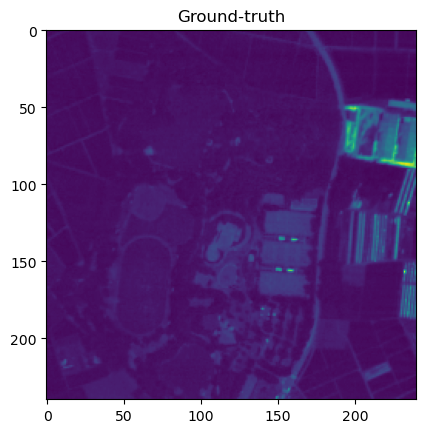

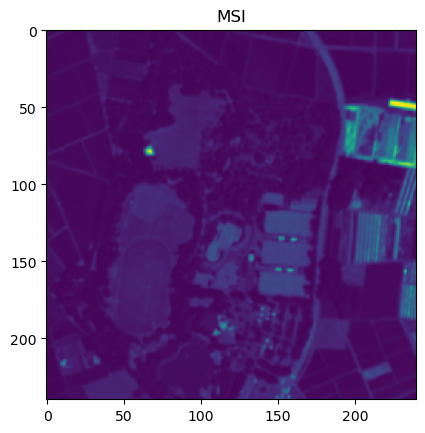

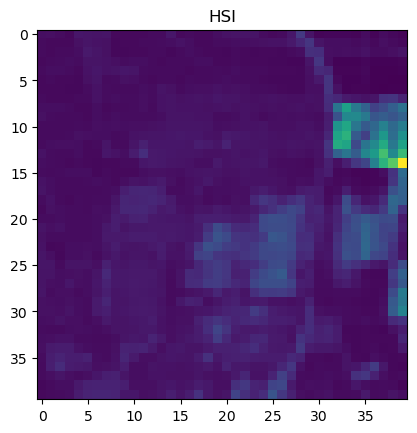

In [17]:
plt.figure(),plt.imshow(data[0,:,:]),plt.title('Ground-truth')
plt.figure(),plt.imshow(MSI[0,:,:]),plt.title('MSI')
plt.figure(),plt.imshow(HSI[0,:,:]),plt.title('HSI')

## II - 2) Simple single image super-resolution

Let us first test a basic method: we spatialy interpolate each spectral band of the HSI by a factor  𝑤  to increase the spatial resolution of the HSI. Note that using this method, we do not perform fusion since we do not use the multispectral image.
Fill the gaps in the code below. You can use the function zoom_bi(im,w) for the interpolation, where im is a 2D image and w the interpolation factor.

In [18]:
HSI_bilin = np.zeros((HSI.shape[0],HSI.shape[1]*w,HSI.shape[2]*w))

for ii in range(HSI.shape[0]):
    HSI_bilin[ii,:,:] = ...

Qualitative evaluation 1: in the cell below, we plot all the spectra associated to a line of the HR-HSI. Compare with the ground-truth in data. Do you see any difference?

(<Figure size 640x480 with 1 Axes>,
 Text(0.5, 1.0, 'Estimation'))

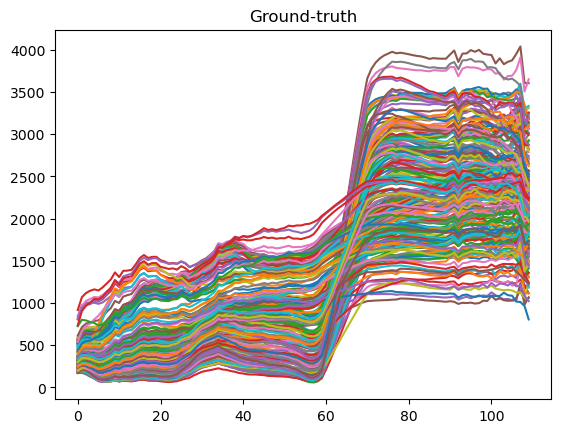

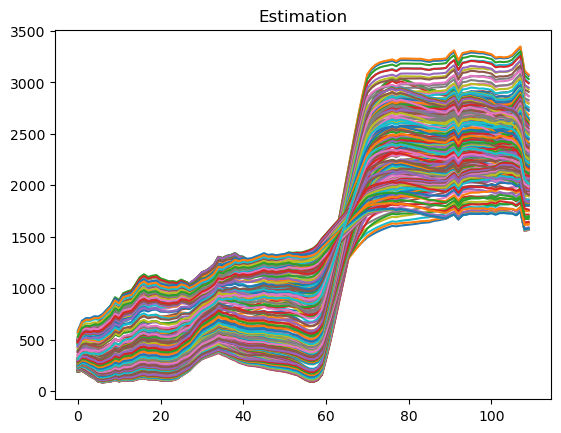

In [19]:
plt.figure(),plt.plot(data[:,120,:]),plt.title('Ground-truth')
plt.figure(),plt.plot(HSI_bilin[:,120,:]),plt.title('Estimation')

Qualitative evaluation 2: now look at the spatial content of the interpolated HSI image. To do that, you can plot a few slices of HSI_bilin and compare with the ground-truth. What do you observe?

**Answer:**

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Estimation'))

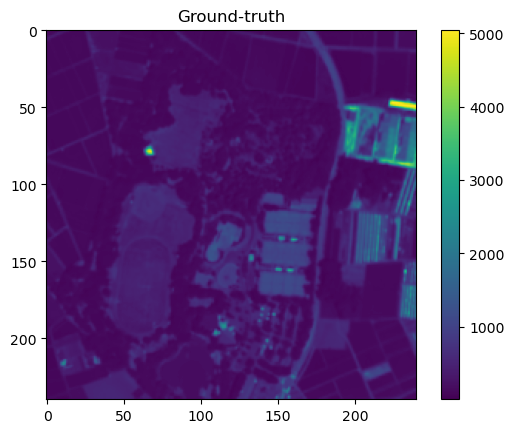

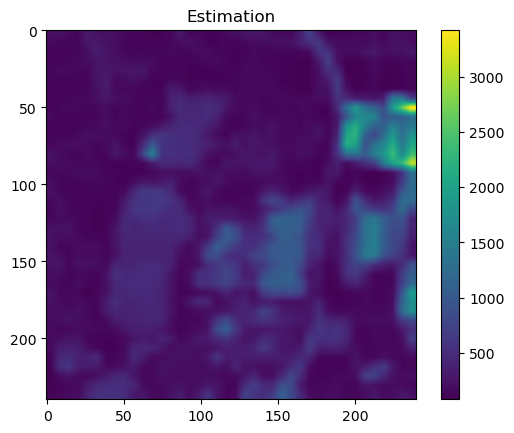

In [20]:
plt.figure(),plt.imshow(data[20,:,:]),plt.colorbar(),plt.title('Ground-truth')
plt.figure(),plt.imshow(HSI_bilin[20,:,:]),plt.colorbar(),plt.title('Estimation')

Quantitative results: we now turn towards metrics to assess our result. The SNR and PSNR might not be the most adapted metric here because of the large scale factors between the super-resolved image and the ground-truth. In addition, to further take into account that there is a spectrum for each pixel, we will rather turn toward a spectral angular distance, the SAD. The function below computes the average SAD over the pixels. Use it to quantitavely evaluate your results (we will compare with other methods later on).

In [21]:
def evalSR(HSI0,HSI_est):
    # HSI0: ground-truth HSI (cube)
    # HSI_est: estimated HSI (cube)
    HSI0 = HSI0.reshape(HSI0.shape[0],HSI0.shape[1]*HSI0.shape[2])
    HSI_est = HSI_est.reshape(HSI_est.shape[0],HSI_est.shape[1]*HSI_est.shape[2])
    
    metriqueTab = np.zeros(HSI0.shape[1])
    for ii in range(HSI0.shape[1]):
        metriqueTab[ii] = np.sum(HSI0[:,ii]*HSI_est[:,ii])/(np.linalg.norm(HSI0[:,ii])*np.linalg.norm(HSI_est[:,ii]))
        
    return np.mean(np.abs(metriqueTab))

In [22]:
print('SAD interpolation bilineaire en dB: ',-10*np.log10(np.abs(1-(evalSR(data,HSI_bilin)))))

SAD interpolation bilineaire en dB:  21.983816288544432


## II - 3) Hyperspectral unmixing + bilinear interpolation of the abundances (single image super-resolution)

In this part, we still use only the HSI, but we try to implement physical constraints by using Nonnegative Matrix Factorization (NMF) to reduce the data dimensionality. We thus obtain a decomposition of the form $X \simeq A_{MU\ HSI}S_{MU\ HSI}$ with $X$ the hyperspectral image and $A_{MU\ HSI},S_{MU\ HSI}$ the endmembers and abundances, respectively. Once the NMF performed, we will use a bilinear interpolation on the abundance maps to obtain $S_{MU\ HSI\ bilin}$, which will be used to synthetise the high resolution HSI: $HSI_{abundance\ bilin} = A_{MU\ HSI}S_{MU\ HSI\ bilin}$.

First step: decompose the HSI using the Multiplicative Update algorithm provided below (reminder: MU is a NMF algorithm). You just have to fill the initialization.

In [23]:
def MULecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1,A = -1, S = -1, frozenA=False):
    '''
    Inputs: 
    %           X: is a [mxn] matrix to unmig
    %
    %           r: size of the matrices A and S
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           A: is a [m x n] matrix 
    %           
    %           S: is a [n x t] matrix c
    %
  '''
    if r is None:
        r=X.shape[0]
    
    if frozenA:
        r = A.shape[1]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    if np.any(A < 0) and (not frozenA):
        A=...
    if np.any(S < 0):
        S= ...   
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # Multiplicative method      
        
        if not frozenA:
            XS=np.dot(X,S.T)
            SS=np.dot(S,S.T)
            A = np.divide(A*XS,np.dot(A,SS) + eps)
        
        S = np.divide(S*np.dot(A.T,X),np.dot(np.dot(A.T,A),S) + eps)

        
        # Convergence indices
        k = k + 1           
        diff=X-np.dot(A,S)     

        delta = np.linalg.norm(diff,'fro') / np.linalg.norm(X,'fro') 
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', np.linalg.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return A,S

Iteration NNMF number  1  out of  1000 , delta =  0.1909172230503606 , error (norm delta):  132680.37195350564
Iteration NNMF number  100  out of  1000 , delta =  0.02922975488906766 , error (norm delta):  20313.592921725518
Iteration NNMF number  200  out of  1000 , delta =  0.01786405487671457 , error (norm delta):  12414.85397582546
Iteration NNMF number  300  out of  1000 , delta =  0.0137054127526083 , error (norm delta):  9524.752312748215
Iteration NNMF number  400  out of  1000 , delta =  0.011297809890910759 , error (norm delta):  7851.557835568483
Iteration NNMF number  500  out of  1000 , delta =  0.009502551813089457 , error (norm delta):  6603.920216960159
Iteration NNMF number  600  out of  1000 , delta =  0.00817120291715272 , error (norm delta):  5678.682232191338
Iteration NNMF number  700  out of  1000 , delta =  0.007229985727869194 , error (norm delta):  5024.57127893161
Iteration NNMF number  800  out of  1000 , delta =  0.006563835301320594 , error (norm delta):  

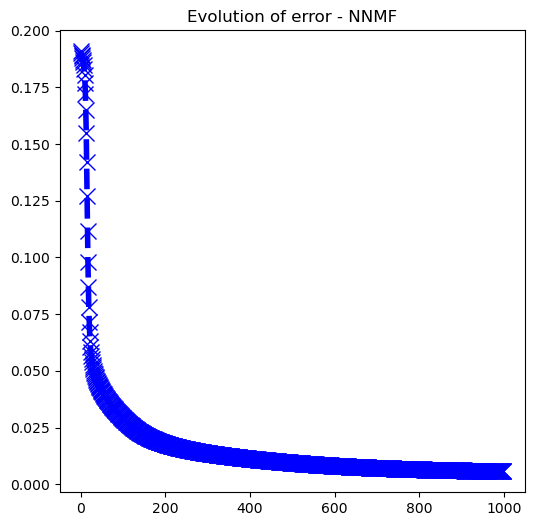

In [24]:
n_MU = 30
#A_MU_HSI,S_MU_HSI = ...
A_MU_HSI,S_MU_HSI = MULecture(HSI.reshape([HSI.shape[0],HSI.shape[1]*HSI.shape[2]]),r=n_MU,N_Iter=1000,tolerance=1e-3,plot_evolution=1)

Now that we have $S_{MU\ HSI}$, let us increase its resolution by a factor $w$ using bilinear interpolation. Store the result in S_MU_HSI_bilin.

In [25]:
S_MU_HSI = S_MU_HSI.reshape([n_MU,HSI.shape[1],HSI.shape[2]])

S_MU_HSI_bilin = np.zeros((S_MU_HSI.shape[0],S_MU_HSI.shape[1]*w,S_MU_HSI.shape[2]*w))

for ii in range(S_MU_HSI.shape[0]):
    S_MU_HSI_bilin[ii,:,:] = zoom_bi(S_MU_HSI[ii,:,:],w)
    #S_MU_HSI_bilin[ii,:,:] = ...

Look at the difference between a few maps and S_MU_HSI and their interpolated versions. What do you observe?

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Interpolated abundance'))

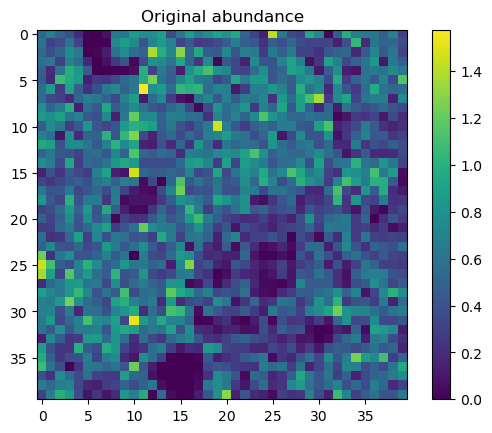

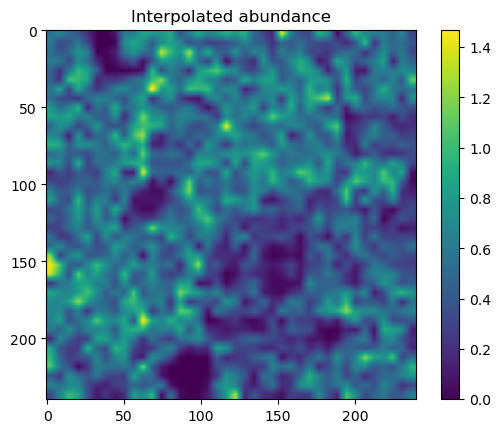

In [26]:
plt.figure(),plt.imshow(S_MU_HSI[8,:,:]),plt.colorbar(),plt.title('Original abundance')
plt.figure(),plt.imshow(S_MU_HSI_bilin[8,:,:]),plt.colorbar(),plt.title('Interpolated abundance')

Second step: synthetise the high resolution HSI by matrix multiplication: $HSI_{abundance\ bilin} = A_{MU\ HSI}S_{MU\ HSI\ bilin}$. Qualitatively Look at your results and compare to the ones obtained in the previous subsection.

In [27]:
HSI_abundance_bilin = np.dot(A_MU_HSI,S_MU_HSI_bilin.reshape(S_MU_HSI_bilin.shape[0],S_MU_HSI_bilin.shape[1]*S_MU_HSI_bilin.shape[2]))
#HSI_abundance_bilin = 

HSI_abundance_bilin = HSI_abundance_bilin.reshape(A_MU_HSI.shape[0],S_MU_HSI_bilin.shape[1],S_MU_HSI_bilin.shape[2])

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'Estimation by bilinear interpolation on the abundance maps'))

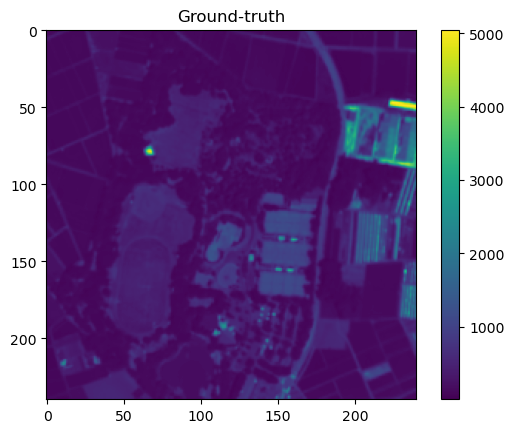

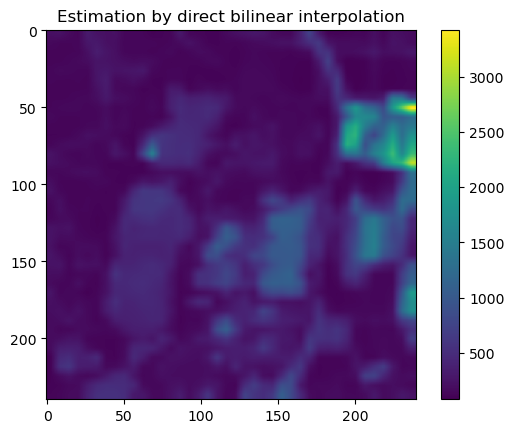

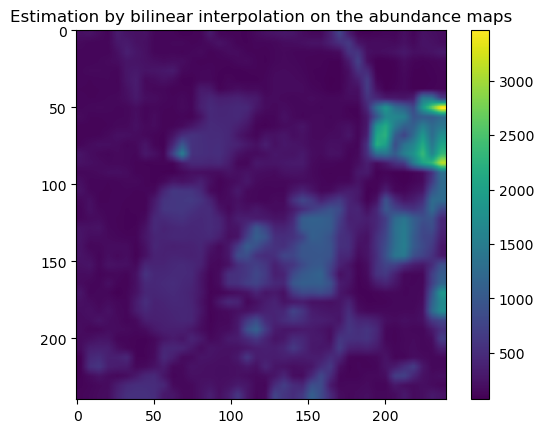

In [28]:
plt.figure(),plt.imshow(data[20,:,:]),plt.colorbar(),plt.title('Ground-truth')
plt.figure(),plt.imshow(HSI_bilin[20,:,:]),plt.colorbar(),plt.title('Estimation by direct bilinear interpolation')
plt.figure(),plt.imshow(HSI_abundance_bilin[20,:,:]),plt.colorbar(),plt.title('Estimation by bilinear interpolation on the abundance maps')

Lastly, look at the quantitative results. Is this new method working well? Why? Try with different number of endmembers.

In [29]:
print('SAD interpolation bilineaire of abundances en dB: ',-10*np.log10(np.abs(1-evalSR(data,HSI_abundance_bilin))))

SAD interpolation bilineaire of abundances en dB:  21.881174674438107


# II - 4) HSI super-resolution with non-blind fusion

To do better than the two above methods, we will try to introduce the spatial information contained in the available multispectral image (MSI) and fuse it with the HSI to obtain a high resolution HSI image. To do that, we will have a simple approach: first perform NMF on the HSI, obtaining $A_{MU\ HSI}$ and $S_{MU\ HSI}$ (this was already done in the last subsection). Then, we will also decompose the MSI into $A_{MU\ MSI}$ and $S_{MU\ MSI}$. Since $A_{MU\ HSI}$ and $S_{MU\ MSI}$ are expected to be of good quality, we will fuse them to obtain the HR-SR image: $HSI_{fusion} = A_{MU\ HSI}S_{MU\ MSI}$.

A difficulty is however that performing unmixing on the MSI is highly difficult since there are few spectral bands in this image. As such, a fully blind approach in which we apply an NMF decomposition to the MSI would not work well. Consequently, it is better to help the unmixing of the MSI with the one of the HSI.

To do that, it is possible to estimate the MSI endmembers from the ones found with the HSI (which are of good quality) using the spectral response function (SRF) that we assume to be known. Mathematically: $A_{MU\ MSI} = SRF\times A_{MU\ HSI}$.

Then, $S_{MU\ MSI}$ can be obtained by solving a nonnegative least-square problem:
\begin{equation}
\arg\min_{S_{MU\ MSI}} \frac{1}{2}\|MSI - A_{MU\ MSI}S_{MU\ MSI}\|_F^2,
\end{equation}

(with MSI into matrix form).


In practice, the optimization problem will be solved applying the MU algorithm with a fixed $A_{MU\ HSI}$.

First fill the cell below to compute A_MU_MSI from the SRF and A_MU_HSI.

In [30]:
#A_MU_MSI = ...
A_MU_MSI = srf@A_MU_HSI
print(A_MU_MSI.shape)

(5, 30)


Then, compute S_MU_MSI by solving the nonnegative least-square problem with the MU. Note that you can use "frozenW = True" in the function parameters to fix A.

Iteration NNMF number  1  out of  1000 , delta =  0.209062081644126 , error (norm delta):  158536.24469976415
Iteration NNMF number  100  out of  1000 , delta =  0.00907422860242597 , error (norm delta):  6881.181488590724
Iteration NNMF number  200  out of  1000 , delta =  0.004603110480918424 , error (norm delta):  3490.6370578724036
Iteration NNMF number  300  out of  1000 , delta =  0.0029377513534667487 , error (norm delta):  2227.75963856071
Iteration NNMF number  400  out of  1000 , delta =  0.0021309000961856287 , error (norm delta):  1615.9070856985684
Iteration NNMF number  500  out of  1000 , delta =  0.0017033938058356353 , error (norm delta):  1291.7199288281763
Iteration NNMF number  600  out of  1000 , delta =  0.001464971545384469 , error (norm delta):  1110.9192330372518
Iteration NNMF number  700  out of  1000 , delta =  0.001325467669567557 , error (norm delta):  1005.1304624522401
Iteration NNMF number  800  out of  1000 , delta =  0.001239968071938885 , error (norm

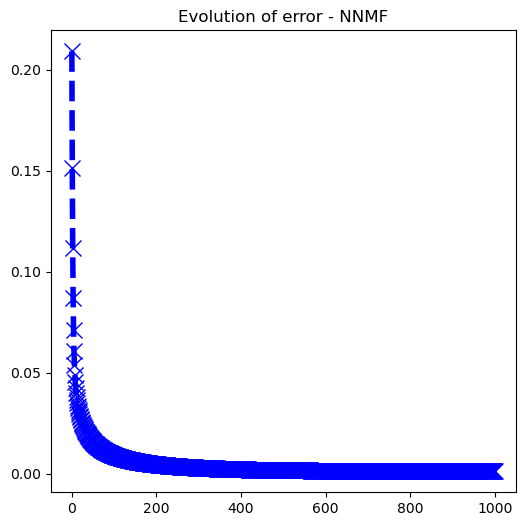

In [31]:
#temp, S_MU_MSI = ...
temp, S_MU_MSI = MULecture(MSI.reshape([MSI.shape[0],MSI.shape[1]*MSI.shape[2]]),N_Iter=1000,tolerance=1e-6,plot_evolution=1,A=A_MU_MSI,frozenA=True)

Compare the HSI abundances and the MSI abundances. What do you observe?

(<Figure size 640x480 with 2 Axes>,
 Text(0.5, 1.0, 'MSI abundances'))

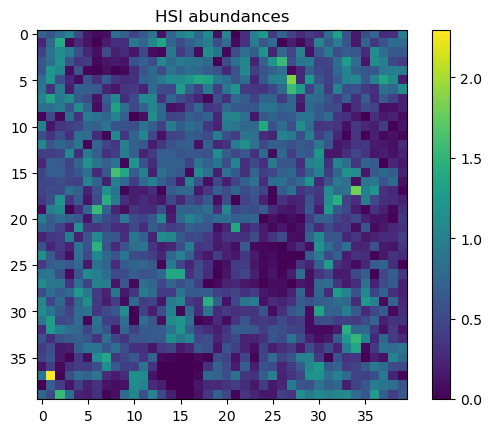

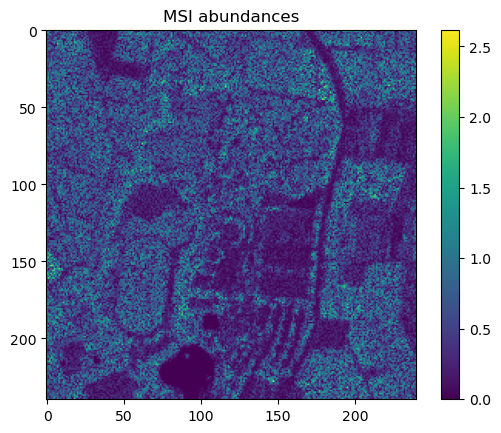

In [32]:
plt.figure(),plt.imshow(S_MU_HSI.reshape(n_MU,HSI.shape[1],HSI.shape[2])[3]),plt.colorbar(),plt.title('HSI abundances')
plt.figure(),plt.imshow(S_MU_MSI.reshape(n_MU,MSI.shape[1],MSI.shape[2])[3]),plt.colorbar(),plt.title('MSI abundances')

Now, generate the fused high-resolution HSI image by multiplying A_MU_HSI and S_MU_MSI.

In [33]:
HSI_fusion = np.dot(A_MU_HSI,S_MU_MSI)
#HSI_fusion = ...

HSI_fusion = HSI_fusion.reshape(HSI.shape[0],MSI.shape[1],MSI.shape[2])

Compare the image obtained through fusion to HSI_abundance_bilin. Comment both the quantitative and qualitative results.

(<Figure size 640x480 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x144ab2f50>)

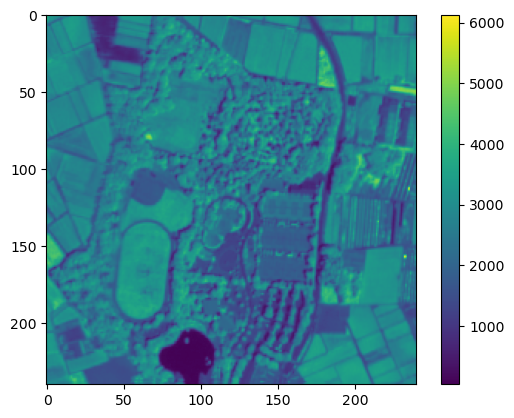

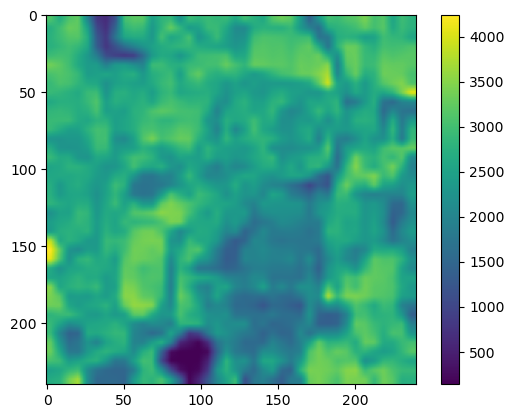

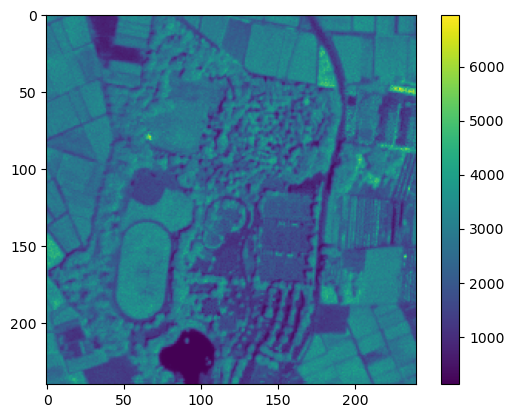

In [34]:
L_obs = 100
plt.figure(),plt.imshow(data[L_obs,:,:]),plt.colorbar(),plt.title('Ground truth')
plt.figure(),plt.imshow(HSI_abundance_bilin[L_obs,:,:]),plt.colorbar(),plt.title('Interpolated abundance')
plt.figure(),plt.imshow(HSI_fusion[L_obs,:,:]),plt.colorbar(),plt.title('Super-resolved HSI')

In [35]:
print('SAD simple fusion: ',-10*np.log10(np.abs(1-evalSR(data,HSI_fusion))))

SAD simple fusion:  27.02598042950352


## II - 5) Coupled nonnegative matrix factorization for fusion

In this last part, we apply the CNMF algorithm, which is a method enabling to properly take into account the links between the MSI and HSI. To do that, it simultaneously perform NMF over the MSI and the HSI using a nested MU algorithm. You just have to launch the code and comment the results.

In [36]:
from CNMF import CNMF_fusion
print('Start CNMF ...')
I_CNMF = CNMF_fusion(HSI_res,MSI_res)

Start CNMF ...


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x14446b5d0>])

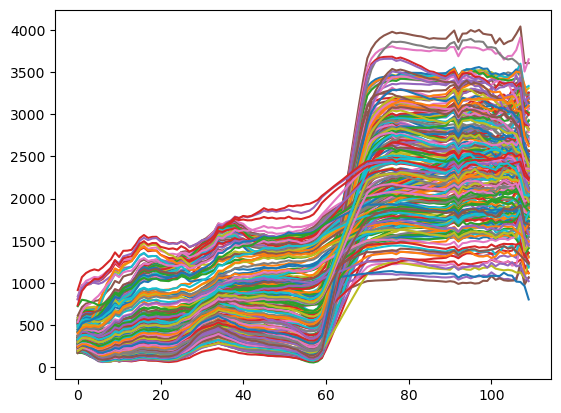

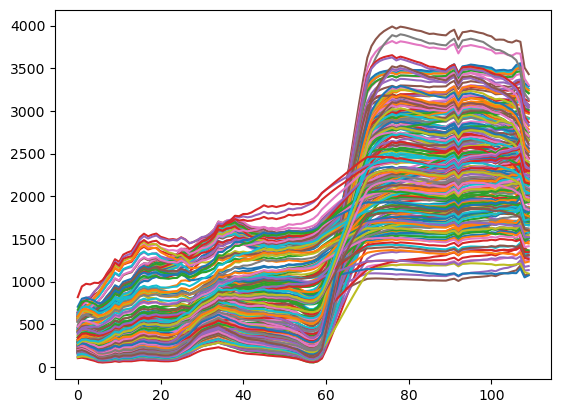

In [37]:
plt.figure(),plt.plot(data[:,120,:])
plt.figure(),plt.plot(I_CNMF.transpose(2,0,1)[:,120,:])

In [38]:
print('Coupled NMF results',-10*np.log10(np.abs(1-evalSR(data,I_CNMF.transpose((2,0,1))))))

Coupled NMF results 35.32452601289395
